# PageRank

## Section 1: Computing PageRank

For this part, I will understand and analyze graphs, first using some basic NetworkX packages and then by implementing matrix-based PageRank. 

After calculating PageRank for a large graph, I will explore how PageRank is affected by adding and deleting certain links in the graph and will gain insight into connectivity.

PageRank can be modeled using matrix operations as follows.  Let $M$ be a _weight transfer matrix_ in which:

$M[i,j] = \frac{1}{n_j}$, if $n_j > 0$ and 

$M[i,j] = 0$ otherwise

where page $i$ is pointed to by page $j$ and page $j$ has $n_j$ outgoing links. And define a _dampening factor_ $\alpha = 0.85$ and a corresponding $\beta = 1 - \alpha$.  Initialize the PageRank vector

$PR^{(0)}=[1,1,1,\ldots]^T$

(i.e., a matrix with m rows by 1 column, filled with ones).  Then we can compute the PageRank $PR$ for each iteration as:

$PR^{(i)}= \alpha \cdot M \cdot PR^{(i-1)} + \beta \cdot [1,1,1,\ldots]^T$

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Step 1.1 Download a web graph and store in a dataframe
The following code retrieves a web graph from https://snap.stanford.edu/data/web-NotreDame.txt.gz, which is a reasonably sized Web crawl done by Notre Dame University, and extracts it into `web-NotreDame.txt`.

In [4]:
import urllib.request
import io
import gzip


for file in ['web-NotreDame.txt']:
    print ('Downloading compressed image of', file)
    source = urllib.request.urlopen("https://snap.stanford.edu/data/" + file + ".gz")
    compressedFile = io.BytesIO(source.read())
    decompressedFile = gzip.GzipFile(fileobj=compressedFile)

    with open(file, 'wb') as outfile:
        outfile.write(decompressedFile.read())
        outfile.close()
        print ('Saved', file)

Saved web-NotreDame.txt


Next, I will write Python code to take the data from `web-NotreDame.txt`, and read and parse the rows in a Pandas DataFrame called `graph_df`. I will restrict the node IDs to values less than 5,000.

In [5]:
graph_df = pd.read_csv('web-NotreDame.txt', skiprows=4, sep='\t', names=['FromNodeId', 'ToNodeId'])
graph_df = graph_df[(graph_df['FromNodeId']<5000) & (graph_df['ToNodeId']<5000)]

graph_df.head(20)

,FromNodeId,ToNodeId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9


### Step 1.2 Load the web graph into a matrix

We will now return to `graph_df` and use it to create a __weight transfer matrix M__, with edges whose weights are scaled as desribed in the beginning.  This will used as input to the PageRank algorithm.

In [6]:
# Create the weight transfer matrix M matrix for graph_df

shape = max(max(graph_df['FromNodeId']), max(graph_df['ToNodeId'])) + 1
matrix = np.zeros((shape, shape))
matrix[graph_df['ToNodeId'], graph_df['FromNodeId']] = 1

total = np.sum(matrix, axis=0)
M = np.nan_to_num(matrix/total)

C:\Users\MaiRZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [7]:
M

array([[0.05882353, 0.04      , 0.        , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.05882353, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05882353, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Step 1.3 Compute matrix-based PageRank
In the following block, we will implement a function `pagerank(M, alpha, num_iter)` that, when given a square $m \times m$ transition matrix $M$ from Step 1.2, initializes the PageRank vector to $m$ 1’s, sets $\alpha$ = `alpha`, sets $\beta$ appropriately given $\alpha$, and iterates `num_iter` times. Return an $m$-element vector that consists of the final PageRank scores.

In [8]:
def pagerank(M, alpha, num_iter):
    rank = np.ones((len(M),1))
    a = alpha
    b = 1 - alpha
    
    for i in range(num_iter):
        dampening = a*M
        rank = np.dot(dampening, rank) + b
        
    return rank

In [9]:
# Execute pagerank() and displays the output
pr = pagerank(M, 0.85, 15)
pr

array([[110.31241416],
       [ 20.62536353],
       [  5.67712058],
       ...,
       [  0.15248362],
       [  0.15248362],
       [  0.15248362]])

We will output a DataFrame called `best_pages_df` with the schema `(id, pagerank)` containing the original IDs and PageRanks of the nodes with top-100 highest PageRank, in descending order.

In [12]:
# Output (id, pagerank) of all nodes, sorted by pagerank.
# The output will be a dataframe

best_pages_df = \
pd.DataFrame(pr).\
reset_index().\
rename(columns={'index':'id', 0:'pagerank'}).\
sort_values('pagerank', ascending=False).reset_index(drop=True)

In [13]:
best_pages_df.head(10)

,id,pagerank
0,0,110.312414
1,1,20.625364
2,140,18.483226
3,162,16.096038
4,238,14.848632
5,214,14.096148
6,16,12.654063
7,14,12.296607
8,1973,12.292720
9,237,9.049141


## Section 2: Manipulating Page Rank

Now, let's look at some ways by which we can manipulate the page rank algorithm to boost the importance of a specific page (node) that we create.

Let the web page that we want to boost be called the **target page**. We assign this node the id value of **5000**; note that this is a new node since it does not exist as `graph_df.FromNodeId` or `graph_df.ToNodeId`. 

### Effect of Adding Outlinks

We will build links from our target page to top-n pages obtained above (`best_pages_sdf`) and observe the outcome on the page rank of our target page.

### Step 2.1: Vary the number of outgoing links and observe effect on PageRank

We will implement a function `runTest(n, best_pages_df)` that returns the PageRank value of the `target` page (i.e., node 5000) whose outgoing links consist of the top-n pages in `best_pages_df`. The function will contain three steps:

1. Create an `edgeList` of outgoing links from the target page to the top `n` pages (fetched from `best_pages_df`) and append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

In [14]:
# Create function runTest(n, best_pages_df) that returns 
# the PageRank value of the target page 
# (node 5000) and calculate pagerank(M, 0.85, 15)

def runTest(n, best_pages_df):
    best_pages_df = best_pages_df.iloc[range(n)]
    edgeList = pd.DataFrame({'FromNodeId':np.ones(n)*5000, 'ToNodeId':best_pages_df['id']})
    graph_df2 = pd.concat([graph_df, edgeList])
    graph_df2['FromNodeId'] = graph_df2['FromNodeId'].astype(int)
    graph_df2['ToNodeId'] = graph_df2['ToNodeId'].astype(int)
    
    shape = int(max(max(graph_df2['FromNodeId']), max(graph_df2['ToNodeId'])) + 1)
    matrix = np.zeros((shape, shape))
    matrix[graph_df2['ToNodeId'], graph_df2['FromNodeId']] = 1

    total = np.sum(matrix, axis=0)
    M = np.nan_to_num(matrix/total)

    pr = pagerank(M, 0.85, 15)
    
    return pr[-1, 0]


The following cell will call `runTest` for the following values of `n : [10,50,100,200,500]`, store the output of these tests in an array `pageRankScores`, and create a scatter plot with the page rank scores of node 5000 against the value of `n` used. 

C:\Users\MaiRZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


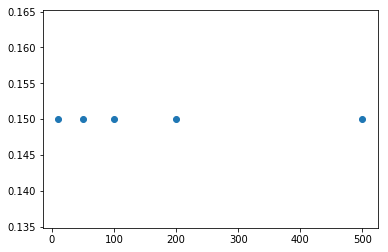

In [15]:
# Call runTest for n=10, 50, 100, 200, 500. 
# Store results in pageRankScores, and visualize the results.

n = [10,50,100,200,500]
pageRankScores = []

for i in n:
    pageRankScores.append(runTest(i, best_pages_df))

plt.scatter(n, pageRankScores)

### Effect of Adding Incoming Links from Other Pages

Using the original `graph_df`, we will now add new __incoming edges__ to the target_page, and observe the difference in the page rank value of the target_page based on the *quantity* as well as *quality* of the incoming links.

### Step 2.2: Add incoming links from different subranges of `best_pages_df`

We will implement a function `runTest2(n, best_pages_df)` that returns the PageRank value of the `target` page (i.e., node 5000) whose incoming links consist of the pages ranked between `n` and `n`+200 (inclusive) in `best_pages_df` and whose outgoing linkes are to the top 100 pages in `best_pages_df`. The function will contain three steps:

1. Create an `edgeList` of outgoing links from the target page to the top 100 pages, and incoming links from pages ranked between `n` and `n`+200 (inclusive) to the target page.  Append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

Thus, 100 outgoing edges and 200 incoming edges will be added for the target page in `graph_df2`.

In [16]:
# Create function runTest2(n, best_pages_df) that returns 
# the PageRank value of the target page (node 5000) 
# and calculates pagerank(M, 0.85, 15)

def runTest2(n, best_pages_df):
    incoming = pd.DataFrame({'FromNodeId':best_pages_df.iloc[n:n+201]['id'], 'ToNodeId':np.ones(201)*5000})
    outgoing = pd.DataFrame({'FromNodeId':np.ones(100)*5000, 'ToNodeId':best_pages_df.iloc[range(100)]['id']})
    edgeList = pd.concat([incoming, outgoing])
    graph_df2 = pd.concat([graph_df, edgeList])
    graph_df2['FromNodeId'] = graph_df2['FromNodeId'].astype(int)
    graph_df2['ToNodeId'] = graph_df2['ToNodeId'].astype(int)
    
    shape = int(max(max(graph_df2['FromNodeId']), max(graph_df2['ToNodeId'])) + 1)
    matrix = np.zeros((shape, shape))
    matrix[graph_df2['ToNodeId'], graph_df2['FromNodeId']] = 1

    total = np.sum(matrix, axis=0)
    M = np.nan_to_num(matrix/total)

    pr = pagerank(M, 0.85, 25)
    
    return pr[-1, 0]

The cell below will run the above test for these values of `n` : [0,100,200,300,400,500,800,1000,2000,3000,4000,4500], store the output in an array `pageRankScores25`, and create a scatter plot with the page rank scores of node 5000 for different values of `n`.

In [17]:
# Call runTest2 for 
# n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
# and visualize the results.

n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
pageRankScores25 = []

for i in n:
    pageRankScores25.append(runTest2(i, best_pages_df))

C:\Users\MaiRZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


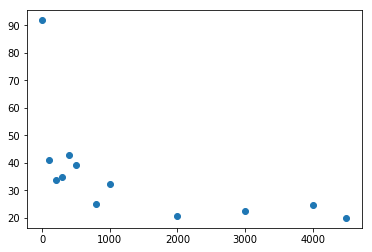

In [21]:
# Plot the result
plt.scatter(n, pageRankScores25)

> We can observe that incoming links from **more influential pages** adds more value to your page and increases its importance as perceived by the page rank.

### Understanding Connectivity
A key takeway from this is that it is not sufficient to have incoming links from influential pages. Although there is a general trend that having incoming links from influential pages increases your page rank, what also matters is whether there is **connectivity** between the nodes that the target_page is linking to and is receiving links from.

We can observe this by changing the list of nodes that the target_page has outgoing links to and observe the change in its page rank value. Instead of the target_page having outgoing links to pages 0-100, we will make it have outgoing links to pages 500-600. We will be able to observe the bump in the page rank value of target_page when it has incoming links from these same set of pages.

### Step 2.3  Effect of overlap in incoming and outgoing links
We will implement a function `runTest3(n, best_pages_df)` that modifies `runTest2()` to have outgoing links to pages 500-600, and again returns the page rank value of the target page (i.e., node 5000).

Here are what the function achieves:
1. Create an `edgeList` of outgoing links from the target page to pages 500-600, and incoming links from pages ranked between `n` and `n`+200 (inclusive) to the target page.  Append `edgeList` to the original `graph_df`, creating a new dataframe of edges `graph_df2`.  Do not overwrite `graph_df`.
2. Using `graph_df2`, create the new weight transfer matrix `M`.  
3. Re-run `pagerank(M, 0.85, 15)` and return the PageRank value of the `target` page.

Again, 100 outgoing edges and 200 incoming edges will be added in total for the target page in `graph_df2`.

In [18]:
# Create function runTest3(n, best_pages_df) in which 
# the target page has outgoing links to pages 500-600 
# and incoming links from pages n to n+200.
# Return the PageRank value of the target page.

def runTest3(n, best_pages_df):
    incoming = pd.DataFrame({'FromNodeId':best_pages_df.iloc[n:n+201]['id'], 'ToNodeId':np.ones(201)*5000})
    outgoing = pd.DataFrame({'FromNodeId':np.ones(101)*5000, 'ToNodeId':best_pages_df.iloc[500:601]['id']})
    edgeList = pd.concat([incoming, outgoing])
    graph_df2 = pd.concat([graph_df, edgeList])
    graph_df2['FromNodeId'] = graph_df2['FromNodeId'].astype(int)
    graph_df2['ToNodeId'] = graph_df2['ToNodeId'].astype(int)
    
    shape = int(max(max(graph_df2['FromNodeId']), max(graph_df2['ToNodeId'])) + 1)
    matrix = np.zeros((shape, shape))
    matrix[graph_df2['ToNodeId'], graph_df2['FromNodeId']] = 1

    total = np.sum(matrix, axis=0)
    M = np.nan_to_num(matrix/total)

    pr = pagerank(M, 0.85, 25)
    
    return pr[-1, 0]

The cell below will run the above test for these values of `n` : [0,100,200,300,400,500,800,1000,2000,3000,4000,4500], store the output in an array called `pageRankScores26`, and create a scatter plot with the PageRank scores of node 5000 for different values of these incoming links.

C:\Users\MaiRZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


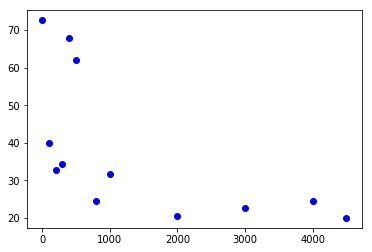

In [19]:
# Call runTest3 for n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
# and visualize the results.

n = [0,100,200,300,400,500,800,1000,2000,3000,4000,4500]
pageRankScores26 = []

for i in n:
    pageRankScores26.append(runTest3(i, best_pages_df))

plt.plot(n,pageRankScores26,'bo') 

### Visualizing the Effect

To get a better understanding of the effect of adding different kinds of links from and to the target page, we plot the values from `pageRankScores25` and `pageRankScores26` in the same plot and compare the differences in the values as we move from 0 to 4500. 

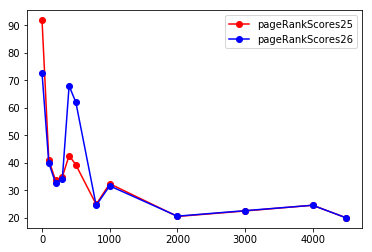

In [20]:
plt.plot(n, pageRankScores25, 'r-o', label='pageRankScores25')
plt.plot(n, pageRankScores26, 'b-o', label='pageRankScores26') 


plt.legend()

---

Note: This is one of the assignments of CIS 545 Big Data Analytics at University of Pennsylvania during Spring 2019.